In [3]:
# %%writefile environment.py
from influxdb import InfluxDBClient
import time
import json
from math import sqrt
from copy import deepcopy
import pdb
import datetime

def write_to_file(file, build_temp, rooms, env, hvac, target_temp):
    room_temp = ''

    for room in rooms:
        room_temp += str(room.state['temperature']) + ','

    file.write(str(build_temp) + ',' + room_temp + str(env.state['temperature']) + ',' + ('1,' if hvac.state['heat_on'] else '0,') + str(hvac.state['temperature']) + ',' + str(target_temp) + '\n')

# create a state class
# create a StateObject parent that every class inherits from for better sense

class StateObject:
    def __init__(self, initial_state):
        self.state = deepcopy(initial_state)
        self.next_state = dict()
    def apply_update(self):
        for key in self.next_state.keys():
            self.state[key] = self.next_state[key]
        self.next_state = dict()
        
class Environment(StateObject):
    def __init__(self, initial_state):
        super().__init__(initial_state)
    def prepare_update(self, next_state):
        self.next_state = next_state

class HVAC(StateObject):
    def __init__(self, initial_state, target_temp):
        super().__init__(initial_state)
        self.state['heat_on'] = False
        self.state['fan_on'] = False
        self.state['target_temp'] = target_temp
        # assume heater can go up to 70
        self.max_heat_temp = 70.0
    
    def prepare_update(self, env, thermostat_temp):
        change = 0.0
        
        if self.state['heat_on']:
            change = 0.1 * (self.max_heat_temp - self.state['temperature'])
        else:
            change = 0.1 * (env.state['temperature'] - self.state['temperature'])

        self.next_state['temperature'] = self.state['temperature'] + change
        self.next_state['heat_on'] = thermostat_temp < self.state['target_temp']
        self.next_state['fan_on'] = thermostat_temp < self.state['target_temp']

class Room(StateObject):
    def __init__(self, room_no, initial_state, hvac):
        super().__init__(initial_state)
        self.hvac = hvac
        self.room_no = room_no
        
        if(room_no==1):
            self.neighbours = ['e', 'e', 2, 8, 9, 'e', 'e', 'e']
        elif(room_no==2):
            self.neighbours = ['e', 'e', 1, 9, 3, 'e']
        elif(room_no==3):
            self.neighbours = ['e', 'e', 2, 9, 4, 'e']
        elif(room_no==4):
            self.neighbours = ['e', 'e', 3, 9, 5, 'e']
        elif(room_no==5):
            self.neighbours = ['e', 'e', 4, 9, 6, 'e', 'e']
        elif(room_no==6):
            self.neighbours = ['e', 'e', 9, 5, 'e', 'e']
        elif(room_no==7):
            self.neighbours = ['e', 'e', 9, 9, 9, 'e']
        elif(room_no==8):
            self.neighbours = ['e', 'e', 1, 9, 9, 'e']
        elif(room_no==9):
            self.neighbours = ['e', 'e', 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 8, 'e']
        
    def prepare_update(self, env, rooms):
        change = 0.0
        
        hvac_contribution = 0.005
        env_contribution = 0.0002
        room_contribution = 0.00005

        if self.hvac.state['fan_on']:
            change += hvac_contribution * (self.hvac.state['temperature'] - self.state['temperature'])
        
        for neighbour in self.neighbours:
            if neighbour=='e':
                change += env_contribution * (env.state['temperature'] - self.state['temperature'])
                #print("env %f / %f" % (env.state['temperature'], self.state['temperature']))
            else:
                change += room_contribution * (rooms[int(neighbour)-1].state['temperature'] - self.state['temperature'])
                #print("room %f / %f" % (rooms[int(neighbour)-1].state['temperature'], self.state['temperature']))
                
        #print('change %d is %f' % (self.room_no, change))
        self.next_state['temperature'] = self.state['temperature'] + change

class Building:
    def __init__(self, initial_state, num_rooms, target_temp):
        self.hvac = HVAC(initial_state, target_temp)
        self.rooms = [Room(i+1, initial_state, self.hvac) for i in range(num_rooms)]            
            
    def prepare_update(self, env):
        self.hvac.prepare_update(env, self.rooms[0].state['temperature'])
        for room in self.rooms:
            room.prepare_update(env, self.rooms)

    def apply_update(self):
        self.hvac.apply_update()
        for room in self.rooms:
            room.apply_update()

class Simulation:
    def __init__(self, initial_state, num_rooms):
        self.num_rooms = num_rooms       
        target_temp = 23.3
        self.env = Environment(initial_state)
        self.house = Building(initial_state, num_rooms, target_temp)

    def update(self, timestamp, client, file):
        response = client.query("SELECT degree_celsius FROM temperature WHERE time = '" + timestamp.strftime("%Y-%m-%dT%H:%M:%SZ") + "'")
        new_env = None
        if len(response) != 0:
            assert(len(response)==1)
            point = list(response.get_points())[0]
            print(point)
            new_env = { 'temperature': point['degree_celsius']}
            
        if (new_env):
                self.env.prepare_update(new_env)
        self.house.prepare_update(self.env)

        self.env.apply_update()
        self.house.apply_update()
        
        # Assumption - Room 1 has the thermostat
        building_temp = self.house.rooms[0].state['temperature']
        
        write_to_file(file, building_temp, self.house.rooms, self.env, self.house.hvac, self.house.hvac.state['target_temp'])

    def showUpdates(self):
        print('ENVIRONMENT')
        print('Updated temperature:', self.env.state['temperature'])

        print('BUILDING')
        for i in range(self.num_rooms):
            print('******************  Room {}  *********************'.format(i+1))
            print('Neighbours: ', self.house.rooms[i].neighbours)
            n = self.house.rooms[i].neighbours
            for j in range(len(n)):
                if(n[j]!='e'):
                    print('    Room ', n[j],': ', self.house.rooms[int(n[j])-1].current_state['temperature'])
                else:
                    print('    Environment: ', self.env.current_state['temperature'])
            print('Updated temperature:', self.house.rooms[i].state['temperature'])
        print("------------------------------------------")
              
def main():
    initial_state = json.loads('{"temperature": 10.00}')
    num_rooms = 9
    sim = Simulation(initial_state, num_rooms)

    timestamp = datetime.datetime.strptime("2020-01-16T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")
    time_step = datetime.timedelta(minutes=1)
    
    # influxdb config
    host = "127.0.0.1"
    port = 8086
    user = 'Shanuj Shekhar'
    password = 'Influxdb@shanuj97'
    dbname = 'weather_data'
    client = InfluxDBClient(host, port, user, password, dbname)

    file = open('output_safe.csv', 'w')
    rooms = ''
    for i in range(num_rooms):
        rooms += 'room' + str(i+1) + ','
    
    file.write('building_temp,' + rooms + 'env_temp,heater,hvac_temp,target_temp\n')
    
    # lifetime of simulation
    for i in range(n):
        sim.update(timestamp, client, file)   
        timestamp += time_step
    file.close()

n = int(input("Enter how many hours you want to visualize since creation:")) * 60
if __name__ == '__main__':
    main()

Enter how many hours you want to visualize since creation:3
{'time': '2020-01-16T00:00:00Z', 'degree_celsius': 3.06}
{'time': '2020-01-16T01:00:00Z', 'degree_celsius': 3.83}
{'time': '2020-01-16T02:00:00Z', 'degree_celsius': 4.16}


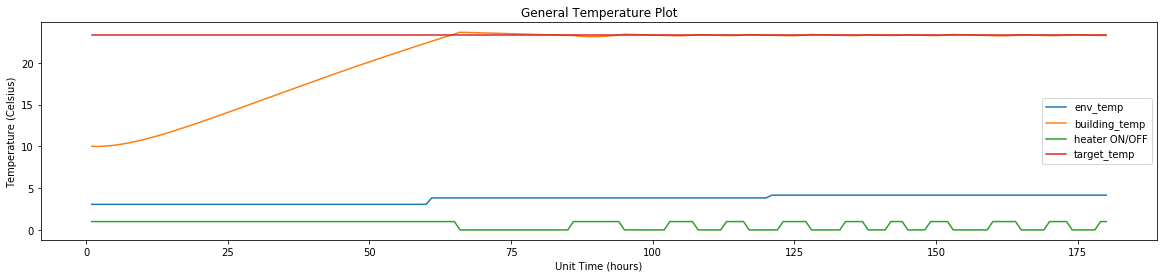

In [5]:
# Plot Graph
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('output_safe.csv')
time_range = range(1, n+1)
data["time_unit"] = time_range
plt.figure(figsize=(20,4))

ax = sns.lineplot(x="time_unit", y="env_temp", data=data, label='env_temp')
ax = sns.lineplot(x="time_unit", y="building_temp", data=data, label='building_temp')
ax = sns.lineplot(x="time_unit", y="heater", data=data, label='heater ON/OFF')
#ax = sns.lineplot(x="time_unit", y="hvac_temp", data=data, label='hvac_temp')
ax = sns.lineplot(x="time_unit", y="target_temp", data=data, label='target_temp')
ax.set(xlabel="Unit Time (hours)", ylabel = "Temperature (Celsius)")
ax.set_title('General Temperature Plot')
plt.show()


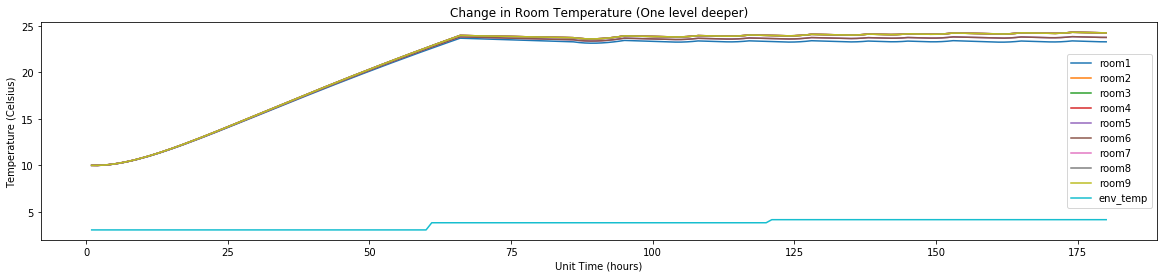

In [6]:
plt.figure(figsize=(20,4))
ax = sns.lineplot(x="time_unit", y="room1", data=data, label='room1')
ax = sns.lineplot(x="time_unit", y="room2", data=data, label='room2')
ax = sns.lineplot(x="time_unit", y="room3", data=data, label='room3')
ax = sns.lineplot(x="time_unit", y="room4", data=data, label='room4')
ax = sns.lineplot(x="time_unit", y="room5", data=data, label='room5')
ax = sns.lineplot(x="time_unit", y="room6", data=data, label='room6')
ax = sns.lineplot(x="time_unit", y="room7", data=data, label='room7')
ax = sns.lineplot(x="time_unit", y="room8", data=data, label='room8')
ax = sns.lineplot(x="time_unit", y="room9", data=data, label='room9')
ax = sns.lineplot(x="time_unit", y="env_temp", data=data, label='env_temp')
ax.set(xlabel="Unit Time (hours)", ylabel = "Temperature (Celsius)")
ax.set_title("Change in Room Temperature (One level deeper)")
plt.show()

In [2]:
from influxdb import InfluxDBClient
import json

# save the db

host = "127.0.0.1"
port = 8086
user = 'Shanuj Shekhar'
password = 'Influxdb@shanuj97'
dbname = 'weather_data'

# query = 'select Float_value from cpu_load_short;'
# query_where = 'select Int_value from cpu_load_short where host=$host;'
# bind_params = {'host': 'server01'}

file = open("data.json", 'r')
json_body = json.load(file)
# print(json_body)
client = InfluxDBClient(host, port, user, password, dbname)

print("Create database: " + dbname)
client.create_database(dbname)

# print("Write points: {0}".format(json_body))
client.write_points(json_body)

# results = client.query('SELECT "degree_celsius" FROM "temperature"')
# # results.raw

# points = results.get_points()
# print(points)
# for point in points:
# #     print(hi)
#     print(point)
#     print("Time: %s, Temperature: %i" % (point['time'], point['degree_celsius']))
# #     break

Create database: weather_data


True